# **0 Imports**

In [85]:
import pandas as pd
import numpy as np
from IPython.display import display
from scipy import stats

import seaborn as sns
import plotly.express as px

from sklearn.model_selection import TimeSeriesSplit

## **0.1 Helper functions**

In [86]:
def week_of_month(x):
    if x == 1:
        return 'primeira'
    elif x == 2:
        return 'segunda'
    elif x == 3:
        return 'terceira'
    elif x == 4:
        return 'quarta'
    else:
        return 'quinta'

def dia_da_semana(df, nome_coluna_data):
    nomes_dias = {
        'Monday': 'segunda',
        'Tuesday': 'terca',
        'Wednesday': 'quarta',
        'Thursday': 'quinta',
        'Friday': 'sexta',
        'Saturday': 'sabado',
        'Sunday': 'domingo'}

    df['dia_da_semana'] = df[nome_coluna_data].dt.day_name().map(nomes_dias)
    
    return df

## **0.2 Load dataset**

In [87]:
item_pedido=pd.read_excel('../data/ITEM_PEDIDO-_2_ _.xlsx',index_col=0)
itens=pd.read_excel('../data/ITENS-_3___.xlsx',index_col=0)
pedido=pd.read_excel('../data/PEDIDO-_1__.xlsx',index_col=0)

# **1 Data description**

## **1.1 Df item_pedido**

In [88]:
display(item_pedido.head())

print(item_pedido.info(),'\n')

print(f"ID's únicos \n{len(item_pedido['ID_PEDIDO'].unique())}",'\n')

quantidades = item_pedido.groupby('ID_ITEM')['QUANTIDADE'].sum().reset_index()
display(quantidades)

print('\n'"Impressões: Alguns ID'S se repetem por conterem mais de um item no pedido e não existe uma diferença discrepante entre a quantidade por item")

,ID_PEDIDO,ID_ITEM,QUANTIDADE
0,120210601,item C,4
1,220210601,item A,3
2,320210604,item C,1
3,420210604,item B,4
4,420210604,item C,2


<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, 0 to 294
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_PEDIDO   295 non-null    int64 
 1   ID_ITEM     295 non-null    object
 2   QUANTIDADE  295 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.2+ KB
None 

ID's únicos 
181 



,ID_ITEM,QUANTIDADE
0,item A,211
1,item B,217
2,item C,216
3,item D,251



Impressões: Alguns ID'S se repetem por conterem mais de um item no pedido e não existe uma diferença discrepante entre a quantidade por item


## **1.2 Df pedido**

In [89]:
display(pedido.head())

print(pedido.info(),'\n')

print(f"ID's únicos \n{len(pedido['ID_PEDIDO'].unique())}",'\n')

pedido['DATA'] = pd.to_datetime(pedido['DATA'])

print(f"Data mínima {pedido['DATA'].min()} e data máxima {pedido['DATA'].max()}",'\n')

print('Impressões: O index possue ao todo 294 contagens, porém a tabela possue 181 linhas; possivelmente 113 linhas não foram imputadas por algum erro')
print('O intervalo das datas é de 3 meses')
print('A coluna VALOR_TOTAL não possue valores imputados')

,ID_PEDIDO,DATA,VALOR_TOTAL
0,120210601,2021-06-01,NaN
1,220210601,2021-06-01,NaN
2,320210604,2021-06-04,NaN
3,420210604,2021-06-04,NaN
5,520210604,2021-06-04,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 181 entries, 0 to 293
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_PEDIDO    181 non-null    int64  
 1   DATA         181 non-null    object 
 2   VALOR_TOTAL  0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.7+ KB
None 

ID's únicos 
181 

Data mínima 2021-06-01 00:00:00 e data máxima 2021-09-01 00:00:00 

Impressões: O index possue ao todo 294 contagens, porém a tabela possue 181 linhas; possivelmente 113 linhas não foram imputadas por algum erro
O intervalo das datas é de 3 meses
A coluna VALOR_TOTAL não possue valores imputados


## **1.3 Df itens**

In [90]:
display(itens)

print('Impressões: Aparenta ser o tipo de entregável esperado pela empresa')

,0
item A,10
item B,15
item C,20
item D,25


Impressões: Aparenta ser o tipo de entregável esperado pela empresa


# **2 Feature engineering**

In [91]:
# Estratégia: 

# unir a tabela item_pedido e pedido, de forma que a tabela final seja igual a tabela pedido,
# porém terá colunas adicionais referentes a todos os items vendidos em determinada data,
# agrupando todas as datas repetidas

## **2.1 Df merge**

In [92]:
# criando uma tabela auxiliar a partir da tabela 'item_pedido' com a coluna ID ITEM quebrada em quatro colunas para cada tipo de item
pivot_table = item_pedido.pivot_table(index='ID_PEDIDO', columns='ID_ITEM', values='QUANTIDADE', fill_value=0).reset_index()

# unindo a tabela 'pedido' com a tabela auxiliar através da coluna 'ID_PEDIDO'
pedido = pedido.merge(pivot_table[['ID_PEDIDO','item A', 'item B', 'item C', 'item D']], on='ID_PEDIDO', how='left')

# agrupando a tabela pedido pela coluna DATA a fim de ter a soma total de cada item por dia 
pedido_grouped = pedido.groupby('DATA').agg({'ID_PEDIDO': 'first',  # mantém o primeiro ID_PEDIDO
                                            'item A': 'sum',
                                            'item B': 'sum',
                                            'item C': 'sum',
                                            'item D': 'sum'}).reset_index()

# dropando coluna que não será utilizada 
pedido_grouped.drop(columns=['ID_PEDIDO'],inplace=True)


# alteração de nome
df=pedido_grouped

# rename columns
df.rename(columns={'DATA':'data','item A':'item_a','item B':'item_b','item C':'item_c','item D':'item_d'},inplace=True)

# change types
df[['item_a', 'item_b', 'item_c', 'item_d']]=df[['item_a', 'item_b', 'item_c', 'item_d']].astype(int)

df

,data,item_a,item_b,item_c,item_d
0,2021-06-01,3,0,4,0
1,2021-06-04,0,6,3,1
2,2021-06-05,5,3,0,1
3,2021-06-06,0,8,4,0
4,2021-06-07,2,1,0,0
...,...,...,...,...,...
76,2021-08-28,1,0,1,4
77,2021-08-29,3,1,3,6
78,2021-08-30,4,0,0,3
79,2021-08-31,3,0,5,3


## **2.2 Train, validation and test separation**

In [93]:
# Definir os dados de entrada e saída
X = df.drop(labels=['item_a','item_b','item_c','item_d'], axis=1)
y = df[['item_a','item_b','item_c','item_d']]

# Definir o TimeSeriesSplit para a divisão em treino, validação e teste
tscv = TimeSeriesSplit(n_splits=3)

# Iterar sobre os splits
for train_index, test_index in tscv.split(X):
    # Dividir os dados em treino e teste
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Dividir os dados de treino em treino e validação (80% treino, 20% validação)
    split_idx = int(len(X_train) * 0.7)
    X_train, X_val = X_train[:split_idx], X_train[split_idx:]
    y_train, y_val = y_train[:split_idx], y_train[split_idx:]

print('Training size')
print(len(X_train))
print(len(y_train))
print(f'Min and max training date {X_train["data"].min().date()} {X_train["data"].max().date()} \n')

print('Validation size')
print(len(X_val))
print(len(y_val))
print(f'Min and max validation date {X_val["data"].min().date()} {X_val["data"].max().date()} \n')

print('Test size')
print(len(X_test))
print(len(y_test))
print(f'Min and max test date {X_test["data"].min().date()} {X_test["data"].max().date()}')

Training size
42
42
Min and max training date 2021-06-01 2021-07-19 

Validation size
19
19
Min and max validation date 2021-07-20 2021-08-12 

Test size
20
20
Min and max test date 2021-08-13 2021-09-01


In [94]:
df = df[df['data'] <= '2021-08-12']

df

,data,item_a,item_b,item_c,item_d
0,2021-06-01,3,0,4,0
1,2021-06-04,0,6,3,1
2,2021-06-05,5,3,0,1
3,2021-06-06,0,8,4,0
4,2021-06-07,2,1,0,0
...,...,...,...,...,...
56,2021-08-06,0,3,1,6
57,2021-08-07,5,0,5,5
58,2021-08-08,5,1,7,0
59,2021-08-10,0,2,0,5


## **2.4 Feature creation**

In [129]:
# soma total de cada item
df['itens_totais'] = df[['item_a', 'item_b', 'item_c', 'item_d']].sum(axis=1)

# dia da semana
df = dia_da_semana(df.loc[:, :], 'data')

# dia do mês
df.loc[:, 'dia'] = df['data'].dt.day

# tipo do dia
df.loc[:, 'tipo_dia'] = df['data'].dt.weekday.apply(lambda x: 'util' if x < 5 else 'fds')

# semana do mês
df.loc[:, 'semana_do_mes'] = df['data'].dt.day.apply(lambda x: week_of_month((x - 1) // 7 + 1))

## **2.5 Data description**

In [96]:
cols = ['item_a', 'item_b', 'item_c', 'item_d']
desc = df[cols].describe().drop(['count', '25%', '50%', '75%'])
desc.loc['sum'] = df[cols].sum()
desc

,item_a,item_b,item_c,item_d
mean,2.393443,2.868852,2.557377,2.950820
std,2.099831,2.963531,2.533276,2.506167
min,0.000000,0.000000,0.000000,0.000000
max,7.000000,10.000000,9.000000,10.000000
sum,146.000000,175.000000,156.000000,180.000000


In [97]:
print(f"Data mínima {df['data'].min()} e máxima {df['data'].max()}",'\n')

print(f"Total de itens a: {df['item_a'].sum()}")
print(f"Total de itens b: {df['item_b'].sum()}")
print(f"Total de itens c: {df['item_c'].sum()}")
print(f"Total de itens d: {df['item_d'].sum()}",'\n')

print(f"Contagem de dias:\n{df['dia_da_semana'].value_counts().to_string(header=False)}",'\n')

print(f"Contagem de semanas do mês:\n{df['semana_do_mes'].value_counts().to_string(header=False)}",'\n')

Data mínima 2021-06-01 00:00:00 e máxima 2021-08-12 00:00:00 

Total de itens a: 146
Total de itens b: 175
Total de itens c: 156
Total de itens d: 180 

Contagem de dias:
sexta      10
sabado     10
domingo    10
terca       9
quinta      8
segunda     7
quarta      7 

Contagem de semanas do mês:
primeira    16
segunda     16
quarta      13
terceira    11
quinta       5 



# **3 EDA**

## **3.1 Univariate analysis**

### **Data**

In [98]:
print(f"Data mínima {df['data'].min()} e máxima {df['data'].max()}",'\n')

Data mínima 2021-06-01 00:00:00 e máxima 2021-08-12 00:00:00 



### **Itens**

In [99]:
px.box(df,y=['item_a','item_b','item_c','item_d'])

In [100]:
fig = px.bar(x=['item_a', 'item_b', 'item_c', 'item_d'],
             y=df[['item_a', 'item_b', 'item_c', 'item_d']].sum(),
             labels={'x': 'Item', 'y': 'Total'},
             title='Total de cada item'); fig.show()

### **Dia da semana**

In [101]:
fig = px.bar(
    x=df['dia_da_semana'].value_counts().index,
    y=df['dia_da_semana'].value_counts().values,
    labels={'x': 'Dia da Semana', 'y': 'Total'},
    title='Contagem de dias'
); fig.show()

### **Dia do mês**

In [102]:
df['dia'].value_counts()

dia
1     3
5     3
6     3
7     3
10    3
12    3
4     2
8     2
30    2
29    2
28    2
27    2
26    2
25    2
23    2
22    2
20    2
19    2
18    2
15    2
14    2
13    2
11    2
9     2
2     1
3     1
16    1
17    1
21    1
24    1
31    1
Name: count, dtype: int64

### **Semanas**

In [103]:
fig = px.bar(
    x=df['semana_do_mes'].value_counts().index,
    y=df['semana_do_mes'].value_counts().values,
    labels={'x': 'Semana do mês', 'y': 'Total'},
    title='Contagem de semanas'
); fig.show()

## **3.2 Bivariate analysis**

### **Hypothesis**

#### **Segunda-feira vende-se 20% a menos em média**

In [104]:
# Calculando a média de itens totais para segundas-feiras
media_segunda = df[df['dia_da_semana'] == 'segunda']['itens_totais'].mean()

# Calculando a média de itens totais para os outros dias da semana
media_outros_dias = df[df['dia_da_semana'] != 'segunda']['itens_totais'].mean()

data = {
    'Dia da semana': ['Segunda-feira', 'Outros dias'],
    'Media de itens totais': [media_segunda, media_outros_dias]
}
df_plot = pd.DataFrame(data)

# Criando o gráfico com Plotly Express
fig = px.bar(df_plot, x='Dia da semana', y='Media de itens totais', color='Dia da semana',
             labels={'Media de itens totais': 'Média de itens totais', 'Dia da semana': 'Dia da semana'},
             title="Média de itens totais em Segundas-feiras vs Outros dias")

# Adicionando uma linha para representar a diferença de 20%
fig.add_hline(y=0.8 * media_outros_dias, line_dash="dash", line_color="red",
               annotation_text="20% menos", annotation_position="bottom right")

# Mostrando o gráfico
fig.show()


# Calculando a diferença percentual
diferenca_percentual = ((media_outros_dias - media_segunda) / media_outros_dias) * 100

print('\n'f"A média de itens totais é {diferenca_percentual:.2f}% menor em segundas-feiras em comparação com os outros dias da semana.")


A média de itens totais é 44.63% menor em segundas-feiras em comparação com os outros dias da semana.


In [105]:
# Separar os dados para segundas-feiras e outros dias da semana
segunda = df[df['dia_da_semana'] == 'segunda']['itens_totais']
outros_dias = df[df['dia_da_semana'] != 'segunda']['itens_totais']

# Realizar o teste t de Student
t_statistic, p_value = stats.ttest_ind(segunda, outros_dias)

# Definir o nível de significância
alpha = 0.05

# Verificar se o valor p é menor que o nível de significância
if p_value < alpha:
    print("A diferença na média de itens totais entre segundas-feiras e outros dias da semana é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre segundas-feiras e outros dias da semana não é estatisticamente relevante.")

print("Valor p:", p_value)

A diferença na média de itens totais entre segundas-feiras e outros dias da semana é estatisticamente relevante.
Valor p: 0.011127424021605686


In [106]:
# Realizar o teste de Mann-Whitney U
u_statistic, p_value = stats.mannwhitneyu(segunda, outros_dias)

# Definir o nível de significância
alpha = 0.05

# Verificar se o valor p é menor que o nível de significância
if p_value < alpha:
    print("A diferença na média de itens totais entre segundas-feiras e outros dias da semana é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre segundas-feiras e outros dias da semana não é estatisticamente relevante.")

print("Valor p:", p_value)

A diferença na média de itens totais entre segundas-feiras e outros dias da semana é estatisticamente relevante.
Valor p: 0.0051851936532309115


#### **Entre sexta a domingo, vende-se em média 30% a mais**

In [107]:
# Separar os dados para sexta a domingo e os outros dias da semana
sexta_a_domingo = df[df['dia_da_semana'].isin(['sexta', 'sabado', 'domingo'])]['itens_totais']
outros_dias = df[df['dia_da_semana'].isin(['segunda', 'terca', 'quarta', 'quinta'])]['itens_totais']

# Calcular as médias para a visualização
media_sexta_a_domingo = sexta_a_domingo.mean()
media_outros_dias = outros_dias.mean()

# Criar um DataFrame para plotar
data = {
    'Periodo': ['Sexta a Domingo', 'Outros dias'],
    'Media de itens totais': [media_sexta_a_domingo, media_outros_dias]
}

df_plot = pd.DataFrame(data)

fig = px.bar(df_plot, x='Periodo', y='Media de itens totais', color='Periodo',
             labels={'Media de itens totais': 'Média de itens totais', 'Periodo': 'Período'},
             title="Média de itens totais: Sexta a Domingo vs Outros dias")

# Mostrar o gráfico
fig.show()

# Calcular a diferença percentual
diferenca_percentual = ((media_sexta_a_domingo - media_outros_dias) / media_outros_dias) * 100

print('\n'f"A média de itens totais de sexta a domingo é {diferenca_percentual:.2f}% maior em comparação com os outros dias da semana.")


A média de itens totais de sexta a domingo é 81.92% maior em comparação com os outros dias da semana.


In [108]:
# Realizar o teste de Mann-Whitney U
u_statistic, p_value = stats.ttest_ind(sexta_a_domingo, outros_dias)

# Definir o nível de significância
alpha = 0.05

# Verificar se o valor p é menor que o nível de significância
if p_value < alpha:
    print("A diferença na média de itens totais entre sexta a domingo e os outros dias da semana é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre sexta a domingo e os outros dias da semana não é estatisticamente relevante.")

print("Valor p:", p_value)

A diferença na média de itens totais entre sexta a domingo e os outros dias da semana é estatisticamente relevante.
Valor p: 5.716134858111313e-08


In [109]:
# Realizar o teste de Mann-Whitney U
u_statistic, p_value = stats.mannwhitneyu(sexta_a_domingo, outros_dias, alternative='two-sided')

# Definir o nível de significância
alpha = 0.05

# Verificar se o valor p é menor que o nível de significância
if p_value < alpha:
    print("A diferença na média de itens totais entre sexta a domingo e os outros dias da semana é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre sexta a domingo e os outros dias da semana não é estatisticamente relevante.")

print("Valor p:", p_value)

A diferença na média de itens totais entre sexta a domingo e os outros dias da semana é estatisticamente relevante.
Valor p: 3.0274280296737237e-07


#### **Do 15° dia até o 5° dia do mês seguinte, vende-se em média 40% a mais**

In [110]:
# Filtrando os dados para o período do dia 15 ao dia 5 do próximo mês (exclusivamente)
periodo_15_a_5 = df[(df['dia'] >= 15) | (df['dia'] <= 5)]['itens_totais']
resto_dos_dias = df[(df['dia'] < 15) & (df['dia'] > 5)]['itens_totais']

# Calcular as médias
media_periodo_15_a_5 = periodo_15_a_5.mean()
media_resto_dos_dias = resto_dos_dias.mean()

# Criar um DataFrame para plotar
data = {
    'Periodo': ['Dia 15 a 5', 'Resto dos dias'],
    'Media de itens totais': [media_periodo_15_a_5, media_resto_dos_dias]
}

df_plot = pd.DataFrame(data)

# Criar o gráfico com Plotly Express
fig = px.bar(df_plot, x='Periodo', y='Media de itens totais', color='Periodo',
             labels={'Media de itens totais': 'Média de itens totais', 'Periodo': 'Período'},
             title="Média de itens totais: Dia 15 a 5 vs Resto dos dias")

# Mostrar o gráfico
fig.show()

# Calcular a diferença percentual
diferenca_percentual = ((media_periodo_15_a_5 - media_resto_dos_dias) / media_resto_dos_dias) * 100

print('\n'f"A média de itens totais do dia 15 ao dia 5 é {diferenca_percentual:.2f}% maior em comparação com o resto dos dias.")


A média de itens totais do dia 15 ao dia 5 é 4.73% maior em comparação com o resto dos dias.


In [111]:
# Realizar o teste de Mann-Whitney U
u_statistic, p_value = stats.ttest_ind(periodo_15_a_5, resto_dos_dias)

# Definir o nível de significância
alpha = 0.05

# Verificar se o valor p é menor que o nível de significância
if p_value < alpha:
    print("A diferença na média de itens totais entre os dias 15 a 5 e o resto dos dias é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre os dias 15 a 5 e o resto dos dias não é estatisticamente relevante.")

print("Valor p:", p_value)

A diferença na média de itens totais entre os dias 15 a 5 e o resto dos dias não é estatisticamente relevante.
Valor p: 0.7164318064069204


In [112]:
# Realizar o teste de Mann-Whitney U
u_statistic, p_value = stats.mannwhitneyu(periodo_15_a_5, resto_dos_dias, alternative='two-sided')

# Definir o nível de significância
alpha = 0.05

# Verificar se o valor p é menor que o nível de significância
if p_value < alpha:
    print("A diferença na média de itens totais entre os dias 15 a 5 e o resto dos dias é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre os dias 15 a 5 e o resto dos dias não é estatisticamente relevante.")

print("Valor p:", p_value)

A diferença na média de itens totais entre os dias 15 a 5 e o resto dos dias não é estatisticamente relevante.
Valor p: 0.9879649247587585


In [113]:
df[df['dia']==15].head(10)

,data,item_a,item_b,item_c,item_d,itens_totais,dia_da_semana,dia,tipo_dia,semana_do_mes
11,2021-06-15,0,4,0,1,5,terca,15,util,terceira
37,2021-07-15,1,0,0,2,3,quinta,15,util,terceira


### **A 1° semana e a 3° semana vendem em média 30% a mais**

In [114]:
# Filtrando os dados para a primeira e terceira semanas e os outros dias
primeira_terceira_semanas = df[df['semana_do_mes'].isin(['primeira', 'terceira'])]['itens_totais']
outras_semanas = df[~df['semana_do_mes'].isin(['primeira', 'terceira'])]['itens_totais']

# Calcular as médias
media_primeira_terceira = primeira_terceira_semanas.mean()
media_outras_semanas = outras_semanas.mean()

# Criar um DataFrame para plotar
data = {
    'Periodo': ['Primeira e Terceira semanas', 'Outras semanas'],
    'Media de itens totais': [media_primeira_terceira, media_outras_semanas]
}

df_plot = pd.DataFrame(data)

# Criar o gráfico com Plotly Express
fig = px.bar(df_plot, x='Periodo', y='Media de itens totais', color='Periodo',
             labels={'Media de itens totais': 'Média de itens totais', 'Periodo': 'Período'},
             title="Média de itens totais: Primeira e Terceira semanas vs Outras semanas")

# Mostrar o gráfico
fig.show()

# Calcular a diferença percentual
diferenca_percentual = ((media_primeira_terceira - media_outras_semanas) / media_outras_semanas) * 100

print('\n'f"A média de itens totais nas primeiras e terceiras semanas é {diferenca_percentual:.2f}% maior em comparação com as outras semanas.")


A média de itens totais nas primeiras e terceiras semanas é 0.12% maior em comparação com as outras semanas.


In [115]:
# Realizar o teste de Mann-Whitney U
u_statistic, p_value = stats.ttest_ind(primeira_terceira_semanas, outras_semanas)

# Definir o nível de significância
alpha = 0.05

# Verificar se o valor p é menor que o nível de significância
if p_value < alpha:
    print("A diferença na média de itens totais entre as primeiras e terceiras semanas e as outras semanas é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre as primeiras e terceiras semanas e as outras semanas não é estatisticamente relevante.")

print("Valor p:", p_value)

A diferença na média de itens totais entre as primeiras e terceiras semanas e as outras semanas não é estatisticamente relevante.
Valor p: 0.9920748155182009


In [116]:
# Realizar o teste de Mann-Whitney U
u_statistic, p_value = stats.mannwhitneyu(primeira_terceira_semanas, outras_semanas, alternative='two-sided')

# Definir o nível de significância
alpha = 0.05

# Verificar se o valor p é menor que o nível de significância
if p_value < alpha:
    print("A diferença na média de itens totais entre as primeiras e terceiras semanas e as outras semanas é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre as primeiras e terceiras semanas e as outras semanas não é estatisticamente relevante.")

print("Valor p:", p_value)

A diferença na média de itens totais entre as primeiras e terceiras semanas e as outras semanas não é estatisticamente relevante.
Valor p: 1.0


### **Data x itens**

In [117]:
# Criar o gráfico de linha
fig = px.line(df, x='data', y='itens_totais', 
              labels={'data': 'Data', 'itens_totais': 'Itens Totais'},
              title="Itens Totais por Data")

# Mostrar o gráfico
fig.show()

In [118]:
# Criar gráfico de linha para o item_a
fig_a = px.line(df, x='data', y='item_a',
                labels={'data': 'Data', 'item_a': 'Item A'},
                title="Tendência do Item A ao Longo do Tempo")

# Criar gráfico de linha para o item_b
fig_b = px.line(df, x='data', y='item_b',
                labels={'data': 'Data', 'item_b': 'Item B'},
                title="Tendência do Item B ao Longo do Tempo")

# Criar gráfico de linha para o item_c
fig_c = px.line(df, x='data', y='item_c',
                labels={'data': 'Data', 'item_c': 'Item C'},
                title="Tendência do Item C ao Longo do Tempo")

# Criar gráfico de linha para o item_d
fig_d = px.line(df, x='data', y='item_d',
                labels={'data': 'Data', 'item_d': 'Item D'},
                title="Tendência do Item D ao Longo do Tempo")

# Mostrar os gráficos
fig_a.show()
fig_b.show()
fig_c.show()
fig_d.show()

### **Dia da semana x itens**

In [119]:
# Definir a ordem dos dias da semana
dias_da_semana_ordem = ['segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 'domingo']
df['dia_da_semana'] = pd.Categorical(df['dia_da_semana'], categories=dias_da_semana_ordem, ordered=True)

# Calcular a média de itens totais por dia da semana
mean_itens_totais_por_dia = df.groupby('dia_da_semana', observed=True)['itens_totais'].mean().reset_index()

# Criar o gráfico de barras
fig = px.bar(mean_itens_totais_por_dia, x='dia_da_semana', y='itens_totais', 
             labels={'itens_totais': 'Média de itens totais', 'dia_da_semana': 'Dia da semana'},
             title="Média de itens totais por dia da semana")

# Mostrar o gráfico
fig.show()

In [120]:
# Selecionar apenas as colunas numéricas e dia da semana
colunas_numericas = ['item_a', 'item_b', 'item_c', 'item_d', 'dia_da_semana']

# Calcular a média de cada item por dia da semana
mean_items_por_dia = df.groupby('dia_da_semana',observed=True)[['item_a', 'item_b', 'item_c', 'item_d']].mean().reset_index()

# Transformar os dados para o formato longo
mean_items_por_dia_long = mean_items_por_dia.melt(id_vars='dia_da_semana', value_vars=['item_a', 'item_b', 'item_c', 'item_d'],
                                                  var_name='Item', value_name='Média')

# Criar o gráfico de barras
fig = px.bar(mean_items_por_dia_long, x='dia_da_semana', y='Média', color='Item', barmode='group',
             labels={'Média': 'Média dos Itens', 'dia_da_semana': 'Dia da Semana'},
             title="Média de Itens por Dia da Semana")

# Mostrar o gráfico
fig.show()

### **Dia do mês x itens**

In [121]:
# Calcular a média de itens totais por dia da semana
mean_itens_totais_por_dia = df.groupby('dia', observed=True)['itens_totais'].mean().reset_index()

# Criar o gráfico de barras
fig = px.bar(mean_itens_totais_por_dia, x='dia', y='itens_totais', 
             labels={'itens_totais': 'Média de itens totais', 'dia_da_semana': 'Dia da semana'},
             title="Média de itens totais por dia da semana")

# Mostrar o gráfico
fig.show()

In [122]:
df[df['dia']==3]

,data,item_a,item_b,item_c,item_d,itens_totais,dia_da_semana,dia,tipo_dia,semana_do_mes
25,2021-07-03,0,9,7,7,23,sabado,3,fds,primeira


### **Semana do mês x items**

In [123]:
# Definir a ordem dos dias da semana
semana_do_mes_ordem = ['primeira','segunda', 'terceira', 'quarta', 'quinta']
df['semana_do_mes'] = pd.Categorical(df['semana_do_mes'], categories=semana_do_mes_ordem, ordered=True)

# Calcular a média de itens totais por tipo do dia
mean_itens_totais_por_dia = df.groupby('semana_do_mes', observed=True)['itens_totais'].mean().reset_index()

# Criar o gráfico de barras
fig = px.bar(mean_itens_totais_por_dia, x='semana_do_mes', y='itens_totais', 
             labels={'itens_totais': 'Média de itens totais'},
             title="Média de itens totais por semana do mês")

# Mostrar o gráfico
fig.show()

## **3.3 Multivariate analysis**

In [124]:
num_attributes = df.select_dtypes( include=['int64'] )
num_attributes.drop(columns='itens_totais',inplace=True)

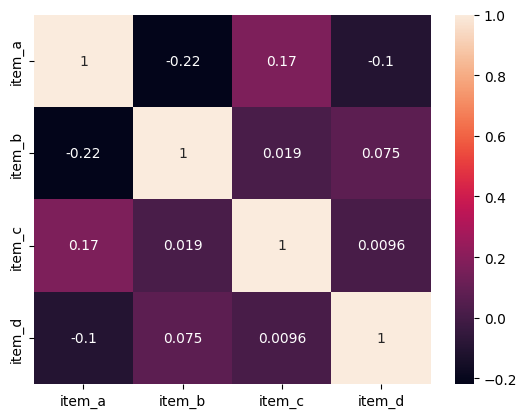

In [125]:
# rcParams['figure.figsize'] = 15,9

correlation=num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

# **4 Data preparation**

In [126]:
# dia da semana
X_train = dia_da_semana(X_train.loc[:, :], 'data')
X_val = dia_da_semana(X_val.loc[:, :], 'data')
X_test = dia_da_semana(X_test.loc[:, :], 'data')

# dia do mês
X_train.loc[:, 'dia'] = X_train['data'].dt.day
X_val.loc[:, 'dia'] = X_val['data'].dt.day
X_test.loc[:, 'dia'] = X_test['data'].dt.day

# tipo do dia
X_train.loc[:, 'tipo_dia'] = X_train['data'].dt.weekday.apply(lambda x: 'util' if x < 5 else 'fds')
X_val.loc[:, 'tipo_dia'] = X_val['data'].dt.weekday.apply(lambda x: 'util' if x < 5 else 'fds')
X_test.loc[:, 'tipo_dia'] = X_test['data'].dt.weekday.apply(lambda x: 'util' if x < 5 else 'fds')

# semana do mês
X_train.loc[:, 'semana_do_mes'] = X_train['data'].dt.day.apply(lambda x: week_of_month((x - 1) // 7 + 1))
X_val.loc[:, 'semana_do_mes'] = X_val['data'].dt.day.apply(lambda x: week_of_month((x - 1) // 7 + 1))
X_test.loc[:, 'semana_do_mes'] = X_test['data'].dt.day.apply(lambda x: week_of_month((x - 1) // 7 + 1))

X_train.drop(columns=['data'],inplace=True)
X_val.drop(columns=['data'],inplace=True)
X_test.drop(columns=['data'],inplace=True)

In [127]:
X_train

,dia_da_semana,dia,tipo_dia,semana_do_mes
0,terca,1,util,primeira
1,sexta,4,util,primeira
2,sabado,5,fds,primeira
3,domingo,6,fds,primeira
4,segunda,7,util,primeira
5,quarta,9,util,segunda
6,quinta,10,util,segunda
7,sexta,11,util,segunda
8,sabado,12,fds,segunda
9,domingo,13,fds,segunda


In [128]:
# possibilidades:

# implementar um algoritmo de time series para prever os 4 itens,
# ou tentar prever individualmente cada item usando os outros itens e as outras colunas como variáveis preditoras 
# caso aja relação entre os itens 
# a segunda provavelmente não é a mais ideal pq ignoraria a sazonalidade 